In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("frg_norm_hssm.csv")
trial_time = 3
stress_dict = {1:'pre',2:'post'}
tt_dict = {5:'short',20:'long'}
leave_resp_filt = df["response"]==0

In [ ]:
# def neg_exp_resp(x,a,b):
#     return a*(1-np.exp(-b*x))

# def cum_rew_func(df,subid,stress_cond,tt_cond,ax,c):
#     subid_filt = df["subj_idx"]==subid
#     stress_filt = df["condition"]==stress_cond
#     tt_filt = df["travel_time"]==tt_cond
#     patch_leave_idx = pd.Index(df[subid_filt & stress_filt & tt_filt & leave_resp_filt].index)
#     patch_entry_idx = pd.Index([df[subid_filt & stress_filt & tt_filt].index[0]]+list(patch_leave_idx+1))
#     patch_trial_idx = [list(range(i,j+1)) for (i,j) in list(zip(patch_entry_idx,patch_leave_idx))]
# #     rel_patch_trial_idx = [np.array(i)-i[0] for i in patch_trial_idx]
#     rel_leave_idxs = list(patch_leave_idx - patch_entry_idx[0])

# ##    for idxs in patch_trial_idx:
# ##        patch_num = patch_trial_idx.index(idxs)
# ##        if len(df.loc[idxs]["travel_time"].unique())>1:
# ##            patch_trial_idx.remove(idxs)

#     env_cum_rew = []
#     patch_cum_rew = []
#     for idxs in patch_trial_idx:
#         patch_num = patch_trial_idx.index(idxs)
#         tot_rew = np.array(df.loc[idxs][:]["tot_reward"])
#         patch_rew = tot_rew-tot_rew[0]
#         env_cum_rew+=list(tot_rew)
#         patch_cum_rew.append(patch_rew)

#     x_data = np.array([trial_time]*len(env_cum_rew))
#     x_data[np.array(rel_leave_idxs)] = tt_cond; x_data[0]=0; x_data = np.cumsum(x_data)
#     env_cum_rew = np.array(env_cum_rew)
#     y_data = env_cum_rew-env_cum_rew[0]
#     reg = LinearRegression(fit_intercept=False).fit(x_data.reshape(-1,1),y_data.reshape(-1,1))
#     slope = reg.coef_; slope = slope.flatten()
    
#     long_patch_len = max([len(i) for i in patch_cum_rew])
#     num_patches = len(patch_cum_rew)
#     patch_len = [len(i) for i in patch_cum_rew]
    
#     stay_lock_patch_rew = np.nan*np.ones((num_patches,long_patch_len))

#     for i in range(num_patches):
#         stay_lock_patch_rew[i] = list(patch_cum_rew[i])+(long_patch_len-len(patch_cum_rew[i]))*[np.nan]
    
#     mean_rew = np.nanmean(stay_lock_patch_rew,0)
#     popt,pcov = [],[]
#     try:
#         popt, pcov = curve_fit(neg_exp_resp, x_data[:len(mean_rew)],mean_rew)
#         ax.plot(x_data[:len(mean_rew)],neg_exp_resp(x_data[:len(mean_rew)],*popt),'-'+c)
#     except RuntimeError:
#         pass
#     ax.plot(x_data,x_data*slope,'--'+c,label=str(subid)+' '+str(stress_dict[stress_cond])+str(tt_dict[tt_cond]))
# #     ax.plot(x_data,y_data,'-'+c,label=str(subid)+' '+str(stress_dict[stress_cond])+str(tt_dict[tt_cond]))
#     ax.plot(x_data[:len(mean_rew)],mean_rew[:],'.'+c)
#     ax.legend()
#     return env_cum_rew,patch_cum_rew,popt,ax

In [ ]:
# fig,ax=plt.subplots()

In [ ]:
# cum_rew_func_params = []

# subid = 7873;

# # stress = 1; tt = 5;  preshort_env_rew,  preshort_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C0'); cum_rew_func_params.append(opt_params)
# stress = 1; tt = 20; prelong_env_rew,   prelong_patch_rew,   opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C1'); cum_rew_func_params.append(opt_params)
# # stress = 2; tt = 5;  postshort_env_rew, postshort_patch_rew, opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C2'); cum_rew_func_params.append(opt_params)
# stress = 2; tt = 20; postlong_env_rew,  postlong_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C3'); cum_rew_func_params.append(opt_params)

# # subid = 15089;
# # 
# # stress = 1; tt = 5;  preshort_env_rew,  preshort_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C4'); cum_rew_func_params.append(opt_params)
# # stress = 1; tt = 20; prelong_env_rew,   prelong_patch_rew,   opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C5'); cum_rew_func_params.append(opt_params)
# # stress = 2; tt = 5;  postshort_env_rew, postshort_patch_rew, opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C6'); cum_rew_func_params.append(opt_params)
# # stress = 2; tt = 20; postlong_env_rew,  postlong_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C7'); cum_rew_func_params.append(opt_params)

# # subid = 45194;

# # stress = 1; tt = 5;  preshort_env_rew,  preshort_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C8'); cum_rew_func_params.append(opt_params)
# # stress = 1; tt = 20; prelong_env_rew,   prelong_patch_rew,   opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C9'); cum_rew_func_params.append(opt_params)
# # stress = 2; tt = 5;  postshort_env_rew, postshort_patch_rew, opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C10'); cum_rew_func_params.append(opt_params)
# # stress = 2; tt = 20; postlong_env_rew,  postlong_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C11'); cum_rew_func_params.append(opt_params)

# preshort_patch_rew
# # np.mean([[preshort_patch_rew],[prelong_patch_rew],[postshort_patch_rew],[postlong_patch_rew]],0)

In [375]:
##Sections for testing:

subid = 7873; 

stress_cond = 2; tt_cond = 5; c='C0'

subid_filt = df["subj_idx"]==subid
stress_filt = df["condition"]==stress_cond
tt_filt = df["travel_time"]==tt_cond
patch_leave_idx = pd.Index(df[subid_filt & stress_filt & tt_filt & leave_resp_filt].index)
patch_entry_idx = pd.Index([df[subid_filt & stress_filt & tt_filt].index[0]]+list(patch_leave_idx+1))
patch_trial_idx = [list(range(i,j+1)) for (i,j) in list(zip(patch_entry_idx,patch_leave_idx))]
# rel_patch_trial_idx = [np.array(i)-i[0] for i in patch_trial_idx]
rel_leave_idxs = list(patch_leave_idx - patch_entry_idx[0])
patch_trial_idx

##    for idxs in patch_trial_idx:
##        patch_num = patch_trial_idx.index(idxs)
##        if len(df.loc[idxs]["travel_time"].unique())>1:
##            patch_trial_idx.remove(idxs)

[[521, 522, 523, 524, 525, 526],
 [527, 528, 529, 530, 531, 532, 533],
 [534, 535, 536, 537, 538, 539, 540],
 [541, 542, 543, 544, 545],
 [546, 547, 548, 549, 550, 551],
 [552, 553, 554, 555, 556, 557],
 [558, 559, 560, 561, 562, 563, 564]]

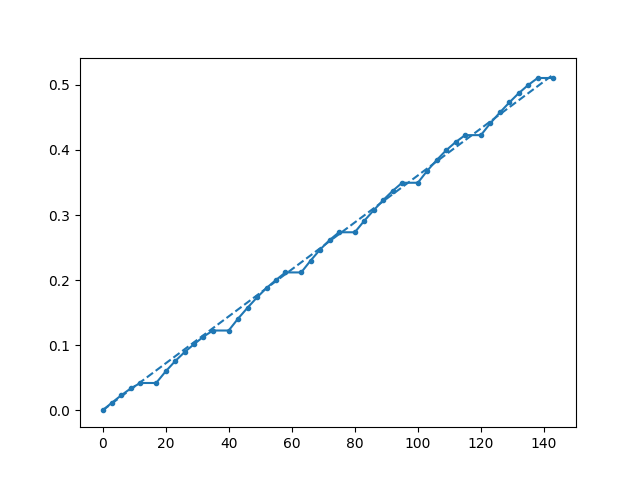

In [386]:
fig,ax=plt.subplots()

env_cum_rew = []
patch_cum_rew = []
for idxs in patch_trial_idx:
    patch_num = patch_trial_idx.index(idxs)
    tot_rew = np.array(df.loc[idxs][:]["tot_reward"])
    patch_rew = tot_rew-tot_rew[0]
    env_cum_rew+=list(tot_rew)
    patch_cum_rew.append(patch_rew)

x_data = np.array([trial_time]*len(env_cum_rew))
x_data[np.array(rel_leave_idxs)] = tt_cond
x_data[0]=0
x_data = np.cumsum(list(x_data))
# print(x_data)

env_cum_rew = np.array(env_cum_rew)
y_data = env_cum_rew-env_cum_rew[0]
# print(y_data)

reg = LinearRegression(fit_intercept=False).fit(x_data.reshape(-1,1),y_data.reshape(-1,1))
slope = reg.coef_; slope = slope.flatten()

ax.plot(x_data,x_data*slope,'--'+c)
ax.plot(x_data,y_data,'.-'+c,label=str(subid)+' '+str(stress_dict[stress_cond])+str(tt_dict[tt_cond]))

In [387]:
long_patch_len = max([len(i) for i in patch_cum_rew])
num_patches = len(patch_cum_rew)
patch_len = [len(i) for i in patch_cum_rew]
# print(num_patches,long_patch_len)

stay_lock_patch_rew = np.nan*np.ones((num_patches,long_patch_len))
# idxs = [0]+list(np.cumsum(patch_len))

#stay_lock
for i in range(num_patches):
#     stay_lock_env_rew[i] = list(env_cum_rew[range(idxs[i],idxs[i+1])])+(long_patch_len-len(env_cum_rew[range(idxs[i],idxs[i+1])]))*[np.nan]
    stay_lock_patch_rew[i] = list(patch_cum_rew[i])+(long_patch_len-len(patch_cum_rew[i]))*[np.nan]

mean_rew = np.nanmean(stay_lock_patch_rew,0)
# ax.plot(x_data[:len(mean_rew)],mean_rew[:],'.k')

def neg_exp_resp(x,a,b):
    return a*(1-np.exp(-b*x))

sub_popt = []
for i in range(num_patches):
    popt, pcov = curve_fit(neg_exp_resp, x_data[:len(patch_cum_rew[i])],patch_cum_rew[i])
    sub_popt.append(popt)
    # ax.plot(x_data[:len(patch_cum_rew[i])],patch_cum_rew[i],'--'+c)#,label="Patch {}".format(patch_num))
    # ax.plot(x_data[:len(patch_cum_rew[i])],neg_exp_resp(x_data[:len(patch_cum_rew[i])],*popt),'-'+c)

sub_popt = np.array(sub_popt)
opt = np.mean(sub_popt,0)   

In [388]:
# patch_len = [0]+[len(i) for i in patch_cum_rew]
# patch_len = np.cumsum(patch_len)
# idxs = [np.array(range(i,j)) for (i,j) in list(zip(patch_len[:-1],patch_len[1:]))]

idxs = [np.array(i)-patch_trial_idx[0][0] for i in patch_trial_idx]
print(idxs)

y = []
for i in range(num_patches):
    x = x_data[idxs[i]]
    if i==0:
        patch_x = x_data[idxs[i]-idxs[i][0]]
    else:
        patch_x = x_data[idxs[i]-idxs[i][0]][1:]
    patch_y = neg_exp_resp(patch_x,*opt)
    patch_y[-1]=patch_y[-2]
    y.append(patch_y)

for i in range(1,num_patches):
    y[i]=np.array(y[i])+y[i-1][-1]

for i in range(num_patches):
    if i==0:
        ax.plot(x_data[idxs[i]],y[i])
    else:
        ax.plot(x_data[idxs[i]][1:],y[i])


[array([0, 1, 2, 3, 4, 5]), array([ 6,  7,  8,  9, 10, 11, 12]), array([13, 14, 15, 16, 17, 18, 19]), array([20, 21, 22, 23, 24]), array([25, 26, 27, 28, 29, 30]), array([31, 32, 33, 34, 35, 36]), array([37, 38, 39, 40, 41, 42, 43])]


In [389]:
#Synthetic data for optimal calculation

n=1
def mvt_opt(n_stay,num_trials,opt,ax,c):
    leave_locs=[0]
    while len(leave_locs)<=num_trials-n_stay:
        leave_locs+=([0]*n_stay+[1])

    leave_idxs = np.where(np.array(leave_locs)==1)[0]
    leave_idxs = leave_idxs[leave_idxs<num_trials]
    entry_idxs = np.array([0]+list(leave_idxs[:-1]+1))
    entry_idxs = entry_idxs[entry_idxs<num_trials]

    t_data = np.array([trial_time]*num_trials);t_data[0]=0
    t_data[leave_idxs] = tt_cond
    t_data = np.cumsum(t_data)
    t_data = t_data[t_data<x_data[-1]]
    leave_idxs = leave_idxs[leave_idxs<len(t_data)]
    entry_idxs = entry_idxs[entry_idxs<len(t_data)]

    trial_idxs = [list(range(i,j)) for (i,j) in list(zip(entry_idxs[:-1],entry_idxs[1:]))]
    rel_trial_idxs = [np.array(i)-i[0] for i in trial_idxs]
    num_patch = len(trial_idxs)

    y = []
    for i in range(num_patch):
        t = t_data[trial_idxs[i]]
        if i==0:
            patch_x = t_data[np.array(rel_trial_idxs[i])]
        else:
            patch_x = t_data[np.array(rel_trial_idxs[i])+1]
        patch_y = neg_exp_resp(patch_x,*opt)
        patch_y[-1]=patch_y[-2]
        y.append(patch_y)

    for i in range(1,num_patch):
        y[i]=np.array(y[i])+y[i-1][-1]

    for i in range(num_patch):
        t = t_data[trial_idxs[i]]
        r = y[i]
#         ax.plot(t,r,c)
    rew = np.concatenate([i for i in y])
    reg = LinearRegression(fit_intercept=False).fit(t_data[:len(rew)].reshape(-1,1),rew.reshape(-1,1))
    slope = reg.coef_; slope = slope.flatten()
    ax.plot(t_data,slope*t_data,label="{}".format(n_stay))
    return slope

sub_num_trials = len(env_cum_rew)
# fig,ax=plt.subplots()
# mvt_opt(3,sub_num_trials,opt,ax,'C'+str(i))

cum_rew = []
for i in range(2,10):
    n_rew = mvt_opt(i,sub_num_trials,opt,ax,'C'+str(i))
    cum_rew.append(n_rew)
ax.legend()

[array([0.00308839]), array([0.00322506]), array([0.0031661]), array([0.00302392]), array([0.0028656]), array([0.00271842]), array([0.00260326]), array([0.00243543])]


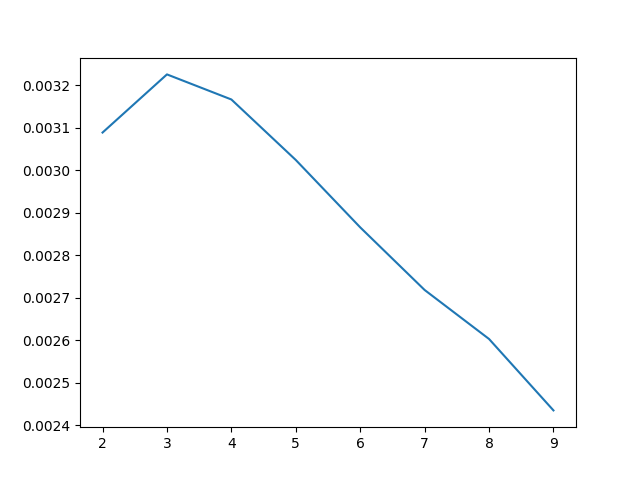

In [380]:
print(cum_rew)
fig2,ax2=plt.subplots()
ax2.plot(range(2,10),cum_rew)

In [313]:
np.concatenate([i for i in y])

array([0.        , 0.02693705, 0.04833523, 0.06533345, 0.07883644,
       0.07883644, 0.10577349, 0.12717167, 0.14416988, 0.15767288,
       0.19859522, 0.20090711, 0.20274363, 0.20420251, 0.20420251,
       0.23113957, 0.25253774, 0.26953596, 0.28303895, 0.3239613 ,
       0.32627319, 0.3281097 , 0.32956859, 0.33072749, 0.3316481 ,
       0.33237941, 0.33296035, 0.33342183, 0.33342183])